In [113]:
import numpy as np
import scipy.io
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import json

from numpy.lib.stride_tricks import sliding_window_view
from opt_einsum import contract
from statsmodels.graphics.tsaplots import plot_acf

### Build Connectome DiGraph

In [114]:
def get_connectome(filepath, sheet_name):
    excel_connectome = pd.read_excel(filepath, sheet_name)
    table = excel_connectome.values[1:,2:]

    neuron_names = set().union(table[1:,0], table[0,1:])
    neuron_names = {x for x in neuron_names if x == x} #remove nans
    neuron_names = sorted(list(neuron_names))

    edge_list = []

    def isnan(x):
        return isinstance(x, float) and np.isnan(x)

    for r in range(1,len(table)):
        for c in range(1,len(table[r])):
            if isnan(table[r][c]) or isnan(table[r][0]) or isnan(table[0][c]):
                continue
            edge_list.append((table[r][0], table[0][c], table[r][c]))

    connectome = nx.DiGraph()
    connectome.add_nodes_from(neuron_names)
    connectome.add_weighted_edges_from(edge_list)
    return connectome

In [115]:
CONNECTOME = get_connectome("datasets/NIHMS1054987-supplement-Supplementary_files/Supplementary Information/SI 5 Connectome adjacency matrices.xlsx", sheet_name="male chemical")

In [116]:
print(sorted(((d,n) for n,d in CONNECTOME.degree), reverse=True))

[(91, 'PVV'), (87, 'AVAR'), (82, 'AVAL'), (80, 'PDB'), (74, 'PVZ'), (69, 'R1BR'), (69, 'HOB'), (68, 'R7BL'), (67, 'PVNL'), (63, 'AVFR'), (62, 'R7BR'), (62, 'PVX'), (60, 'EF2'), (59, 'PHCL'), (57, 'AVG'), (56, 'R3BR'), (56, 'AVFL'), (54, 'AVBR'), (52, 'R2BL'), (52, 'PVY'), (51, 'RIAL'), (51, 'R9AR'), (51, 'R3BL'), (51, 'R2BR'), (51, 'EF3'), (51, 'CP09'), (50, 'VA12'), (50, 'PHCR'), (50, 'CA05'), (50, 'AVDR'), (49, 'hyp'), (49, 'SMDDL'), (49, 'R5BR'), (49, 'PVCL'), (49, 'HOA'), (49, 'CP07'), (48, 'SMDDR'), (48, 'RIAR'), (48, 'CP04'), (47, 'SMDVL'), (47, 'R9BL'), (47, 'DVA'), (46, 'SMBVL'), (46, 'PCAL'), (46, 'CP05'), (45, 'R7AL'), (45, 'PCBR'), (45, 'DVF'), (44, 'SMBDR'), (44, 'CP06'), (44, 'AVBL'), (43, 'R7AR'), (43, 'PVNR'), (43, 'PCAR'), (42, 'R4BR'), (41, 'R9BR'), (41, 'R9AL'), (41, 'PCBL'), (40, 'R6AR'), (40, 'R4BL'), (40, 'PVCR'), (40, 'PQR'), (39, 'RIH'), (39, 'DVC'), (39, 'DA08'), (38, 'SMDVR'), (38, 'SMBVR'), (38, 'EF1'), (38, 'DD06'), (38, 'AVDL'), (37, 'RIML'), (37, 'RIBR'), (

In [117]:
fake_connectome = get_connectome('datasets/fake_test_data/fake_connectome.xlsx', 'S1S2N1')

In [118]:
class TraceObject:
    def __init__(self, json_filepath):
        with open(json_filepath) as trace_file:
            self.trace_json = json.load(trace_file)
            
        self.num_neurons = self.trace_json['num_neurons']

        self.traces = np.array(self.trace_json['trace_array'])

        self.trace_indices = {}
        for i in range(self.trace_json['num_neurons']):
            if str(i+1) in self.trace_json['labeled']:
                self.trace_indices[self.trace_json['labeled'][str(i+1)]['label']] = i  # neurons are 1-indexed

    def get_label(self, i):
        if str(i+1) not in self.trace_json['labeled']:
            return "" # empty string indicates neuron at index i is unlabeled
        return self.trace_json['labeled'][str(i+1)]['label']
    
    def get_index(self, label):
        if label not in self.trace_indices:
            return -1
        return self.trace_indices[label]
        

In [119]:
def get_relevant_mask(neuron, trace_obj, connectome=CONNECTOME):
    relevant_neurons = set().union([neuron], connectome.successors(neuron), connectome.predecessors(neuron))
    return np.array([trace_obj.get_label(i) in relevant_neurons for i in range(trace_obj.num_neurons)])

In [120]:
w_rr = 2
w_sr = 0

In [121]:
def calculate_c(neuron, trace_obj, window_start=0, window_width=None, connectome=CONNECTOME):
    if window_width == None:
        window_width = trace_obj.traces.shape[1] - window_start
    num_windows = window_width - max(w_rr,w_sr) + 1

    traces = trace_obj.traces[:,window_start : window_start + window_width]

    
    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)
    self_index = trace_obj.get_index(neuron)
    if self_index == -1:
        raise ValueError(f"Neuron {neuron} does not have any labeled traces in this dataset.")

    # TODO: We incur a T x relevant_count x w_rr x 1 x (w_sr+1) (about 3000x) blowup here - there is a LOT of redundancy that might be used to bring this down.
    # relevant_count x w_rr x 1 x (w_sr+1) (about 3000) is the number of entries in C
    relevant_sliding_window = np.squeeze(sliding_window_view(traces[relevant_mask,max(w_sr-w_rr,0):], (relevant_count, w_rr), writeable=False), axis=0)
    self_sliding_window = np.squeeze(sliding_window_view(traces[self_index:self_index+1,max(w_rr-w_sr,0):], (1, w_sr), writeable=False), axis=0)
    self_sliding_window = np.concatenate((np.ones((num_windows, 1, 1)), self_sliding_window), axis=2)
    A = contract("tij,tkl->tijkl", relevant_sliding_window, self_sliding_window).reshape(num_windows, relevant_count * w_rr * (w_sr + 1))
    A = A[:-1,:] # can't predict outside of observation window

    # Looking to minimize Ac - traces[neuron]
    observation = traces[self_index][max(w_rr,w_sr):]
    c = np.linalg.inv(A.T @ A) @ A.T @ observation

    plt.plot(np.arange(num_windows-1), observation)
    plt.show()

    plt.plot(np.arange(num_windows-1), A @ c)
    plt.show()

    print(np.linalg.norm(observation - A @ c))

    return c

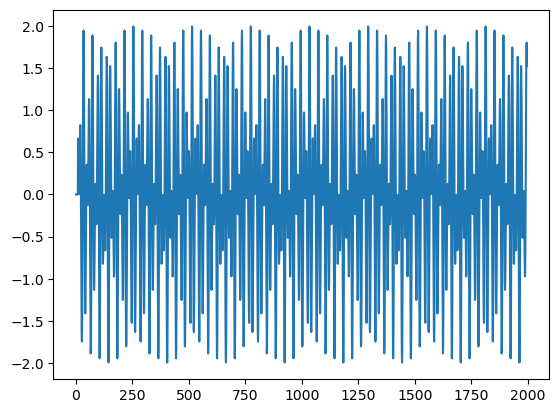

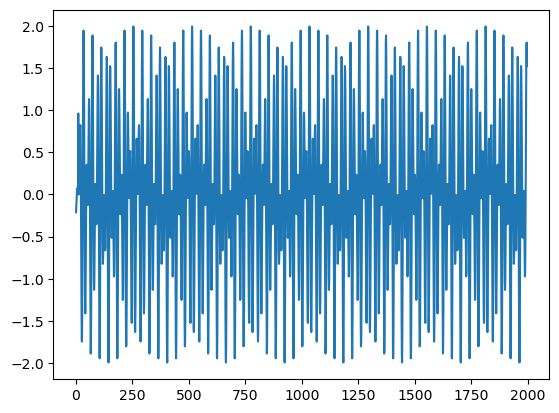

0.8437254557240734
(6,)


In [122]:
trace_obj = TraceObject('datasets/fake_test_data/fake_traces.json')
print(calculate_c('N1', trace_obj, connectome=fake_connectome).shape)

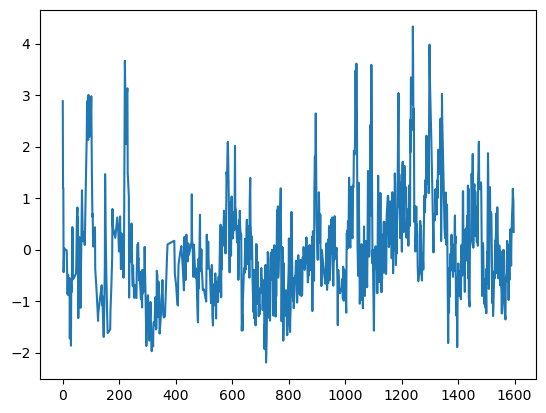

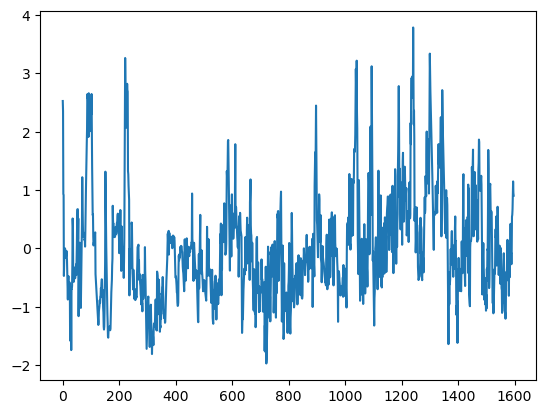

17.389898198182248
(10,)


In [123]:
trace_obj = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
print(calculate_c('SAADR', trace_obj).shape)

In [124]:
def live_simulation(c, neuron, trace_obj, start=w_rr, runtime=None, connectome=CONNECTOME):
    if runtime == None:
        runtime = trace_obj.traces.shape[1] - start

    predicted_trace = []
    relevant_mask = get_relevant_mask(neuron, trace_obj, connectome)
    relevant_count = np.count_nonzero(relevant_mask)
    self_index = trace_obj.get_index(neuron)
    
    C = c.reshape((relevant_count,w_rr,1,w_sr+1))

    for t in range(start,start+runtime):
        relevant_history = trace_obj.traces[relevant_mask,t-w_rr:t]
        self_history = trace_obj.traces[self_index:self_index+1,t-w_sr:t]
        augmented_self_history = np.concatenate((np.ones((1,1)), self_history), axis=1)
        predicted_trace.append(contract("ij,ijkl,kl", relevant_history, C, augmented_self_history))

    observation = np.array(trace_obj.traces[self_index,start:start+runtime])
    plt.plot(np.arange(runtime), observation)
    plt.show()

    prediction = np.array(predicted_trace)
    plt.plot(np.arange(runtime), prediction)
    plt.show()

    print(np.linalg.norm(observation - prediction))

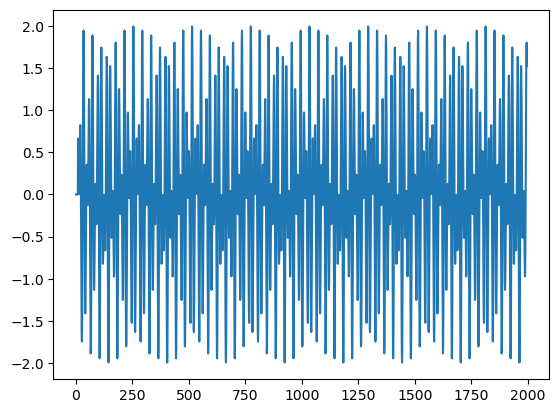

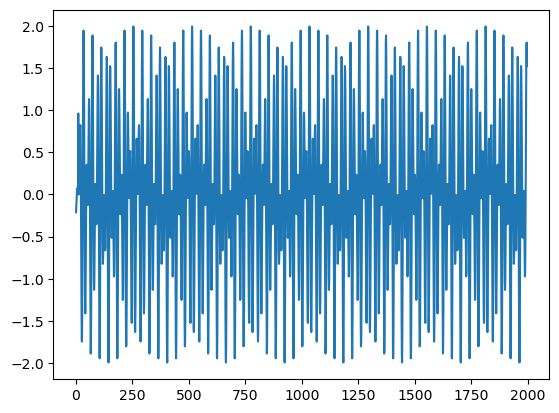

0.8437254557240734


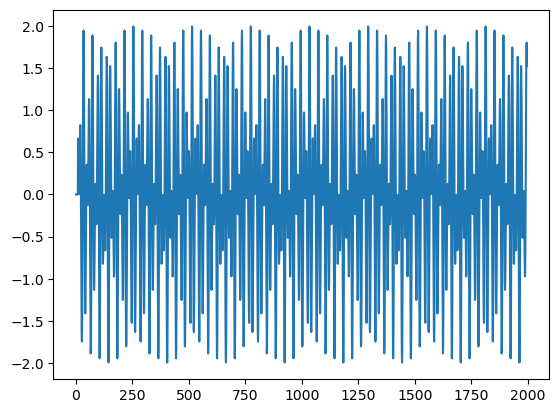

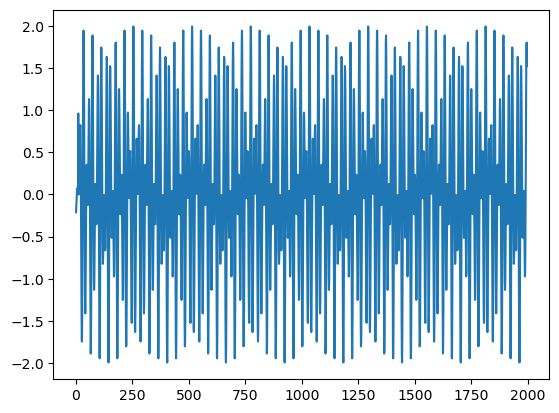

0.8437254557240734


In [125]:
trace_obj = TraceObject('datasets/fake_test_data/fake_traces.json')
c = calculate_c('N1', trace_obj, connectome=fake_connectome)
live_simulation(c, 'N1', trace_obj, connectome=fake_connectome)

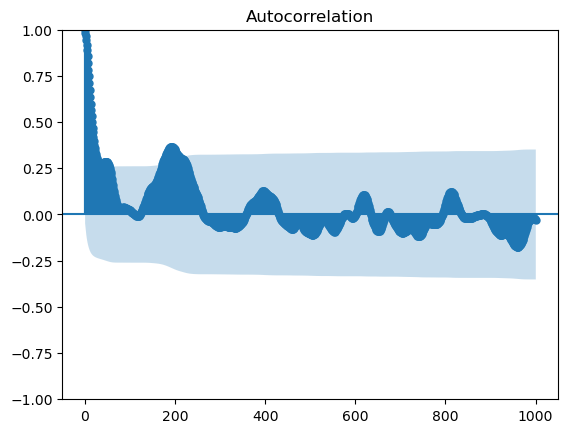

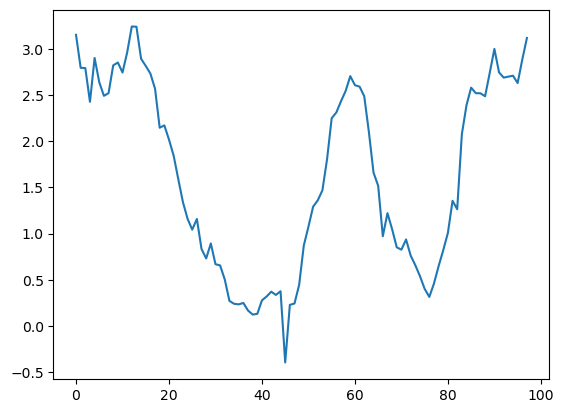

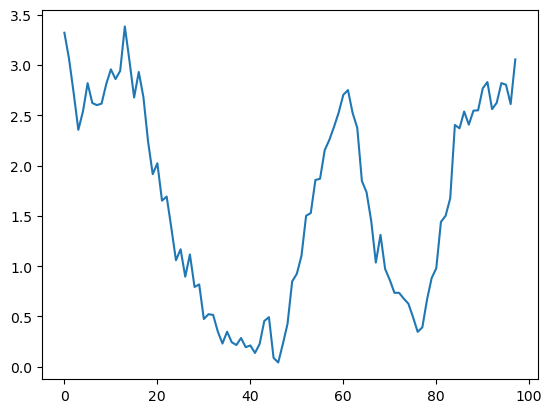

1.6865462140453107


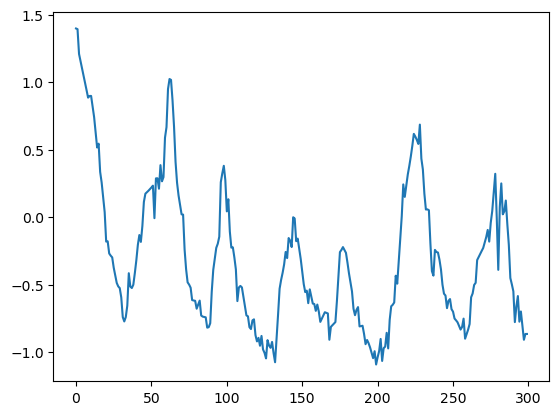

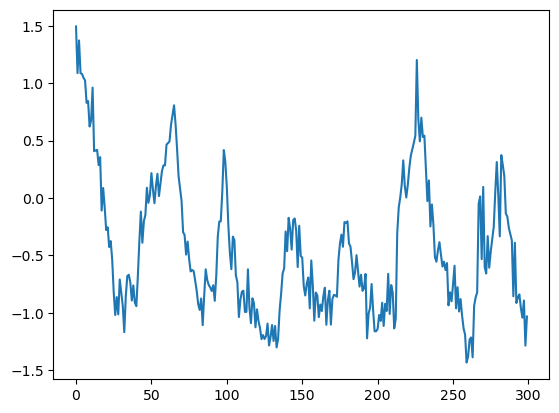

4.452124256771107
30
[ 2.08647888e-02  3.61399120e-02 -1.29419419e-01 -7.12687724e-02
  1.03958691e-02 -1.50785945e-01 -2.68443482e-02  6.20988579e-01
  5.87307454e-04  9.88809789e-02 -2.07742538e-01  3.15012515e-01
 -1.76591928e-01  2.68690162e-01 -1.52220182e-01  3.42230247e-01
  3.74184038e-02 -1.28282304e-02  5.04917841e-05 -1.81049694e-02
  6.07320048e-02 -8.18720913e-02 -2.11481103e-02  1.45749765e-01
  1.12534876e-01 -3.09048068e-02  3.81036780e-02 -1.34774057e-03
 -1.34291387e-01  2.55482333e-01]


In [126]:
neuron = 'AVAR'

trace_obj = TraceObject('datasets/wormwideweb/2022-08-02-01.json')
self_index = trace_obj.get_index(neuron)
if self_index == -1:
    raise ValueError(f"Neuron {neuron} does not have any labeled traces in this dataset.")

plot_acf(trace_obj.traces[self_index,:], lags=1000)
plt.show()

c = calculate_c(neuron, trace_obj, 0, 100)
live_simulation(c, neuron, trace_obj, 1300)

print(len(c))
print(c)